# Import Necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

2024-02-15 14:39:38.992158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 14:39:38.992354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 14:39:39.158584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory data analysis

**Load train and test data**

In [2]:
train_metadata = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
test_metadata = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
sample_submission = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")

**Display dataset overview**

In [3]:
print("Train Metadata:")
print(train_metadata.info())


Train Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106800 entries, 0 to 106799
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   eeg_id                            106800 non-null  int64  
 1   eeg_sub_id                        106800 non-null  int64  
 2   eeg_label_offset_seconds          106800 non-null  float64
 3   spectrogram_id                    106800 non-null  int64  
 4   spectrogram_sub_id                106800 non-null  int64  
 5   spectrogram_label_offset_seconds  106800 non-null  float64
 6   label_id                          106800 non-null  int64  
 7   patient_id                        106800 non-null  int64  
 8   expert_consensus                  106800 non-null  object 
 9   seizure_vote                      106800 non-null  int64  
 10  lpd_vote                          106800 non-null  int64  
 11  gpd_vote                          10

In [4]:
print("\nTest Metadata:")
print(test_metadata.info())



Test Metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   spectrogram_id  1 non-null      int64
 1   eeg_id          1 non-null      int64
 2   patient_id      1 non-null      int64
dtypes: int64(3)
memory usage: 152.0 bytes
None


In [5]:
print("\nSample Submission:")
print(sample_submission.info())


Sample Submission:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   eeg_id        1 non-null      int64  
 1   seizure_vote  1 non-null      float64
 2   lpd_vote      1 non-null      float64
 3   gpd_vote      1 non-null      float64
 4   lrda_vote     1 non-null      float64
 5   grda_vote     1 non-null      float64
 6   other_vote    1 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 184.0 bytes
None


**Load EEG and spectrogram data**

In [6]:
import pandas as pd
import os

# Function to load EEG data from Parquet files
def load_eeg_data(file):
    try:
        data = pd.read_parquet(file)
        return data
    except FileNotFoundError:
        print(f"File {file} not found.")

# Function to load spectrogram data from Parquet files
def load_spectrogram_data(file):
    try:
        data = pd.read_parquet(file)
        return data
    except FileNotFoundError:
        print(f"File {file} not found.")

# Specify relevant file links based on the provided list and competition goal
train_eegs_files = [
    '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1001487592.parquet'
]  # List of file paths for training EEG data

test_eegs_files = [
    '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/3911565283.parquet'
]  # List of file paths for test EEG data

train_spectrograms_files = [
    '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000086677.parquet',
    '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000189855.parquet',
    '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000317312.parquet',
    '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000381196.parquet',
    '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/1000493950.parquet'
]  # List of file paths for training spectrogram data

test_spectrograms_files = [
    '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/853520.parquet'
]  # List of file paths for test spectrogram data

# Load relevant EEG data
train_eegs = []
for file in train_eegs_files:
    data = load_eeg_data(file)
    if data is not None:
        train_eegs.append(data)

test_eegs = []
for file in test_eegs_files:
    data = load_eeg_data(file)
    if data is not None:
        test_eegs.append(data)

# Load relevant spectrogram data
train_spectrograms = []
for file in train_spectrograms_files:
    data = load_spectrogram_data(file)
    if data is not None:
        train_spectrograms.append(data)

test_spectrograms = []
for file in test_spectrograms_files:
    data = load_spectrogram_data(file)
    if data is not None:
        test_spectrograms.append(data)



In [7]:
# View the first few rows of each DataFrame
print("Train EEGs Data:")
for df in train_eegs:
    print(df.head())




Train EEGs Data:
         Fp1         F3         C3          P3         F7         T3  \
0  64.070000  58.750000  60.349998   82.410004  83.209999  74.430000   
1 -68.849998 -70.180000 -65.400002  -41.740002 -43.330002 -47.849998   
2 -59.810001 -59.020000 -49.450001  -17.010000 -29.240000 -29.770000   
3  70.709999  72.839996  80.019997  110.059998  98.360001  98.089996   
4 -48.119999 -43.599998 -37.220001  -15.150000 -21.000000 -22.059999   

           T5          O1         Fz         Cz         Pz         Fp2  \
0   81.879997   77.360001  50.240002  46.520000  64.599998  105.800003   
1  -42.529999  -21.000000 -78.690002 -81.349998 -49.980000  -34.290001   
2  -17.010000   -2.660000 -67.790001 -59.549999 -30.570000  -21.000000   
3  111.650002  102.610001  60.880001  70.980003  88.260002  119.360001   
4  -13.820000    1.860000 -55.029999 -56.889999 -24.459999   -5.580000   

          F4         C4          P4          F8          T4          T6  \
0  80.550003  57.689999   81.6

In [8]:
print("\nTest EEGs Data:")
for df in test_eegs:
    print(df.head())




Test EEGs Data:
         Fp1         F3         C3     P3         F7     T3         T5     O1  \
0   9.210000 -47.459999  15.100000   8.22 -16.900000 -22.99 -25.820000 -10.09   
1  -3.590000 -30.290001  32.380001  10.80 -68.980003 -21.60 -15.080000  -9.21   
2 -26.040001 -60.070000   2.370000 -10.15 -34.689999 -31.40 -31.920000 -26.98   
3  -3.040000 -36.250000  29.559999  14.53 -14.010000 -11.90 -14.230000  -6.31   
4  -4.630000 -20.160000  25.190001   1.19 -44.580002 -23.51 -30.709999 -17.60   

          Fz     Cz         Pz         Fp2         F4     C4     P4  \
0  28.370001  -3.01 -27.299999  101.040001  35.110001  14.54  18.33   
1  26.360001  -8.98 -32.279999   95.800003  26.389999   4.82  10.54   
2  -1.940000 -28.77 -49.770000   73.449997  -3.680000 -17.32 -16.15   
3  26.040001  -2.77 -25.030001   91.010002  22.610001   6.90   9.93   
4  25.420000  -8.86 -33.959999   89.449997  19.440001  -2.08   6.11   

          F8         T4         T6     O2         EKG  
0  28.540001 

In [9]:
print("\nTrain Spectrograms Data:")
for df in train_spectrograms:
    print(df.head())



Train Spectrograms Data:
   time    LL_0.59    LL_0.78    LL_0.98    LL_1.17    LL_1.37    LL_1.56  \
0     1  28.680000  53.990002  67.629997  59.880001  50.880001  74.309998   
1     3  29.639999  38.959999  44.009998  66.800003  48.509998  42.180000   
2     5   8.890000   9.020000  16.360001  23.559999  27.340000  30.040001   
3     7   1.770000   1.930000   1.810000   1.600000   1.430000   1.280000   
4     9        NaN        NaN        NaN        NaN        NaN        NaN   

     LL_1.76    LL_1.95    LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  \
0  78.480003  63.080002  59.869999  ...      0.13      0.14      0.08   
1  47.340000  48.599998  40.880001  ...      0.15      0.13      0.08   
2  27.559999  23.290001  15.120000  ...      0.12      0.11      0.08   
3   1.190000   1.110000   1.010000  ...      0.03      0.03      0.03   
4        NaN        NaN        NaN  ...       NaN       NaN       NaN   

   RP_18.75  RP_18.95  RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92 

In [10]:

print("\nTest Spectrograms Data:")
for df in test_spectrograms:
    print(df.head())


Test Spectrograms Data:
   time    LL_0.59    LL_0.78    LL_0.98  LL_1.17  LL_1.37  LL_1.56  LL_1.76  \
0     1  14.910000  17.110001  11.660000    11.73     6.08     4.54     4.31   
1     3  11.130000  10.950000  10.770000     5.07     4.03     3.24     3.61   
2     5  10.880000  10.570000   8.790000     5.33     2.44     1.48     1.83   
3     7  19.450001  18.200001  17.719999    13.38     4.17     1.88     1.84   
4     9  21.650000  22.530001  23.160000    17.00     7.19     3.89     3.65   

   LL_1.95  LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  RP_18.95  \
0     3.38     2.05  ...      0.07      0.06      0.05      0.06      0.05   
1     2.98     1.54  ...      0.05      0.04      0.04      0.04      0.04   
2     0.99     0.89  ...      0.04      0.04      0.04      0.03      0.03   
3     1.22     1.27  ...      0.03      0.03      0.05      0.08      0.07   
4     2.72     2.35  ...      0.04      0.04      0.05      0.05      0.06   

   RP_19.14  RP_19.34  RP

In [11]:
# Model building
def create_model(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
import numpy as np
train_eegs_array = np.array(train_eegs)
print(train_eegs_array.shape)


(1, 11600, 20)


In [13]:
import pandas as pd
train_metadata_df = pd.DataFrame(train_metadata)
metadata_features = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
metadata_subset = train_metadata_df[metadata_features]
print(metadata_subset.shape)


(106800, 6)


In [14]:
train_eegs_reshaped = train_eegs_array.reshape(11600, 20)


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train_eegs_array = np.array(train_eegs)
train_eegs_reshaped = train_eegs_array.reshape(11600, 20)

# Assuming metadata_subset is the target labels
metadata_features = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
metadata_subset = train_metadata_df[metadata_features]

# Align the number of samples in metadata_subset with train_eegs_reshaped
metadata_subset_subset = metadata_subset.iloc[:11600]  

# Perform train-test split
X_train, X_val, y_train, y_val = train_test_split(train_eegs_reshaped, metadata_subset_subset, test_size=0.2, random_state=42)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Train the model
model = create_model(input_shape=(X_train.shape[1], 1))
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, batch_size=32, validation_data=(np.expand_dims(X_val, axis=-1), y_val))


Epoch 1/10
290/290 [==============================] - 3s 6ms/step - loss: 645555.5000 - accuracy: 0.1675 - val_loss: 1890481.6250 - val_accuracy: 0.1586
Epoch 2/10
290/290 [==============================] - 1s 4ms/step - loss: 14321111.0000 - accuracy: 0.1720 - val_loss: 18212074.0000 - val_accuracy: 0.1586
Epoch 3/10
290/290 [==============================] - 1s 4ms/step - loss: 65322724.0000 - accuracy: 0.1773 - val_loss: 72497360.0000 - val_accuracy: 0.1586
Epoch 4/10
290/290 [==============================] - 1s 4ms/step - loss: 170864256.0000 - accuracy: 0.1745 - val_loss: 213573680.0000 - val_accuracy: 0.1586
Epoch 5/10
290/290 [==============================] - 1s 4ms/step - loss: 357496288.0000 - accuracy: 0.1809 - val_loss: 424347072.0000 - val_accuracy: 0.1586
Epoch 6/10
290/290 [==============================] - 1s 4ms/step - loss: 660069312.0000 - accuracy: 0.1773 - val_loss: 688214656.0000 - val_accuracy: 0.1586
Epoch 7/10
290/290 [==============================] - 1s 4ms/

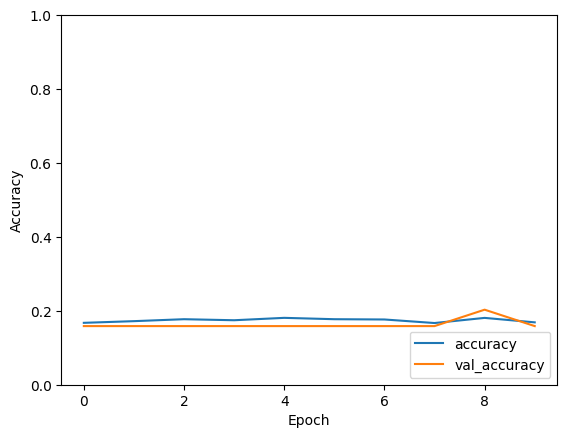

In [17]:
# Model evaluation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [18]:

import numpy as np

# Assuming `test_eegs` is your test data
test_eegs_array = np.array(test_eegs)

# Aggregate the features (take the mean across the last axis)
test_eegs_aggregated = np.mean(test_eegs_array, axis=1)  # Aggregate along the 10000 features

# Reshape the data to match the model's input shape
test_eegs_reshaped = np.expand_dims(test_eegs_aggregated, axis=-1)

# Now, you can use this reshaped data for prediction
test_predictions = model.predict(test_eegs_reshaped)


1/1 [==============================] - 0s 136ms/step


In [19]:
# Submission preparation

#submission_df = pd.DataFrame(test_predictions, columns=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
#submission_df.insert(0, 'eeg_id', test_metadata['eeg_id'])


# Create submission dataframe with correct column names and eeg_id
submission_df = pd.DataFrame(columns=['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
submission_df['eeg_id'] = test_metadata['eeg_id']

# Assign test predictions to respective columns
submission_df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']] = test_predictions

# Save submission file
submission_df.to_csv('submission.csv', index=False)


In [20]:
print(submission_df.head())
submission_df.to_csv('submission.csv', index=False)

       eeg_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0  3911565283           0.0       0.0       0.0        0.0        0.0   

   other_vote  
0         1.0  
